# Mouse Tracking starting from a Deeplabcut csv file

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns # we will see in the next lesson
import matplotlib.pyplot as plt
import csv
import glob
import os
import cv2
import matplotlib.patches as patches
import math
from scipy.spatial import distance

## Opening .csv and .mp4 files

In [3]:

# Loading the .csv file containing the (x,y) coordinates of mouse nose, right ear, left ear, bottom, middle tail and end tail obtained from DLC
csvFilePath = path of the csv file
# Loading the .mp4 file 
videoFilePath = path of the mp4 filedf = pd.read_csv(
    csvFilePath, 
    header=[1,2], #setting the first 2 rows as column names
    dtype =np.float64, #defining the type of the objects inside the dataframe
    index_col=0 #Take the first column as index by default
    ) 


#Open the video file
cap = cv2.VideoCapture(
    videoFilePath
   ) 


## Arena Selection by User

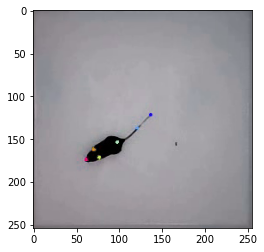

In [4]:
try:
    numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Select a random frame
    chosenFrame = np.random.randint(1, high=numOfFrames)
    
    # Set the chosen frame as current frame
    cap.set(cv2.CAP_PROP_POS_FRAMES,chosenFrame)
    _, chosenFrame = cap.read()

    # User manual selection of the arena
    roi=cv2.selectROI('Select the arena, then press space and enter', chosenFrame) 
    roi_cropped=chosenFrame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
    plt.imshow(roi_cropped)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()


    arenaSelection = input('Do you want to change your selection?[y/n]')
    while arenaSelection == 'y':
         roi=cv2.selectROI(chosenFrame) #save the coordinates of the top left corner and the bottom right corner
         roi_cropped=chosenFrame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
         plt.imshow(roi_cropped)
         cv2.waitKey(0) # Wait until there is key input or automatically eliminate the window after 1000ms, 
         #0 means only use the key input to end the window
         cv2.destroyAllWindows()
         arenaSelection = input('Do you want to change your selection?[y/n]')
  
# Selecting Open Field or Trial analysis    
    trialSelection = input('Are you analysing an open field or a Trial?[of/t]')
    if trialSelection == 't':
         obj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', chosenFrame)
         cv2.waitKey(0)
         cv2.destroyAllWindows()
         ballSelection = input('Do you want to change your selection? [y/n]')
         
         while ballSelection == 'y':
             obj1Roi = cv2.selectROI('Select the object on the right, then press space and enter', chosenFrame)
             cv2.waitKey(0)
             cv2.destroyAllWindows()
             ballSelection = input('Do you want to change your selection? [y/n]')
         
         obj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', chosenFrame)
         cv2.waitKey(0)
         cv2.destroyAllWindows()
         saltSelection = input('Do you want to change your selection? [y/n]')
         
         while saltSelection == 'y':
             obj2Roi = cv2.selectROI('Select the object on the left, then press space and enter', chosenFrame)
             cv2.waitKey(0)
             cv2.destroyAllWindows()
             saltSelection = input('Do you want to change your selection? [y/n]')    
             
except:
    print('An error occurred while getting a frame for the video.')
finally:
    cap.release()  #I have to close the file


# Approximating the selected arena to a square
arenaSide = (roi[2] + roi[3])/2 
xThresholdLeft = roi[0]
xThresholdRight = roi[0] + arenaSide
yThresholdUp = roi[1]
yThresholdDown = roi[1] + arenaSide

## Remapping points falling outside the arena

In [6]:
bodyParts = df.keys()
dfRemapped = df.copy()
for ib in range(bodyParts.size): 
    for i in range(dfRemapped.shape[0]): 
        if bodyParts[ib][1] == 'x':
            if dfRemapped[bodyParts[ib]][i] < xThresholdLeft:
                dfRemapped[bodyParts[ib]][i] = xThresholdLeft
            if dfRemapped[bodyParts[ib]][i] > xThresholdRight:
                dfRemapped[bodyParts[ib]][i] = xThresholdRight
            else:
                if bodyParts[ib][1] == 'y':
                    if dfRemapped[bodyParts[ib]][i] < yThresholdUp:
                        dfRemapped[bodyParts[ib]][i] = yThresholdUp
                    if dfRemapped[bodyParts[ib]][i] > yThresholdDown:
                        dfRemapped[bodyParts[ib]][i] = yThresholdDown
print('Coordinates correctly remapped!')


Coordinates correctly remapped!


## Normalizing body parts coordinates and eventual objects to [0,1]

In [8]:
##Body parts coordinates
dfScaled = dfRemapped.copy()
for ib in range(bodyParts.size): #For every tracked body part
    if bodyParts[ib][1] == 'x':
         dfScaled[bodyParts[ib]] = (dfScaled[bodyParts[ib]] - roi[0])/arenaSide
    else:
        if bodyParts[ib][1] == 'y':
            dfScaled[bodyParts[ib]] = (dfScaled[bodyParts[ib]] - roi[1])/arenaSide

##Objects coordinates
if trialSelection == 't':
    scaledObj1 = np.array([obj1Roi[0]-roi[0], obj1Roi[1]-roi[1], obj1Roi[2], obj1Roi[3]])
    scaledObj1 = scaledObj1/arenaSide
    scaledObj2 = np.array([obj2Roi[0]-roi[0], obj2Roi[1]-roi[1], obj2Roi[2], obj2Roi[3]])
    scaledObj2 = scaledObj2/arenaSide

print("Normalization done")

Normalization done


## Creating Heatmaps and tracking images

total distance in cm: 1629.0896763946805
average speed: 4.629849402410043
time spent in the center: 243.76666666666668
time spent in the periphery 66.9


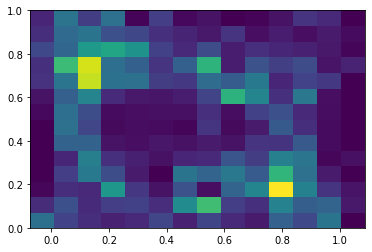

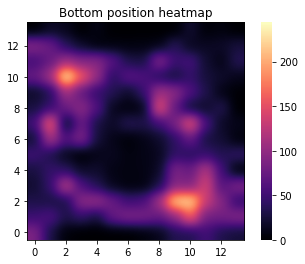

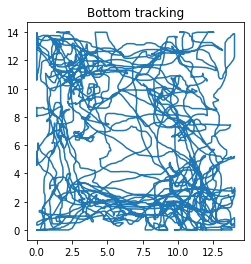

In [16]:
# Selecting the starting time point
drop = True
dropInd = 0
possibilities = 0

while drop:
    if dfScaled[('nose','likelihood')][dropInd] < 0.80:
        dropInd = dropInd + 1
    else:
        if possibilities > 3:
            drop = False
        else:
            possibilities = possibilities + 1
            dropInd = dropInd +1


droppedDfScaled = dfScaled.iloc[dropInd:][:]
droppedDfRemapped = dfRemapped.iloc[dropInd:][:]

#################################################################################################################
# HEATMAPS
#################################################################################################################

#Defining the number of bins
nBins = 14
binLength = 1/nBins

    
#Recalculating objects position based on the number of bins
if trialSelection == 't':
    binScaledObj1 = scaledObj1.copy()
    binScaledObj2 = scaledObj2.copy()
    for i in range(scaledObj1.shape[0]):
        binScaledObj1[i]= scaledObj1[i]/binLength
    for i in range(scaledObj2.shape[0]):
        binScaledObj2[i] = math.floor(scaledObj2[i]/binLength)

h, x, y, p = plt.hist2d(droppedDfScaled[('nose','y')], droppedDfScaled[('nose','x')], bins = nBins)


    
# Create figure and axes
fig, ax1 = plt.subplots()
    
# Display the image
im = ax1.imshow(h, origin = "lower", interpolation = "gaussian", cmap = "magma",)
cbar = ax1.figure.colorbar(im) #to set the cbar
cbar.outline.set_visible(False)
    
# Create patches for the objects
if trialSelection == 't':
    rect1 = patches.Circle((binScaledObj1[0]+binScaledObj1[2]/2, binScaledObj1[1]+binScaledObj1[3]/2), binScaledObj1[2]/2, linewidth=2, linestyle='--', edgecolor='w', facecolor= "None")
    rect2 = patches.Circle((binScaledObj2[0]+binScaledObj2[2]/2, binScaledObj2[1]+binScaledObj2[3]/2), binScaledObj2[2]/2, linewidth=2, linestyle='--', edgecolor='w', facecolor= "None")

    # Add the patches to the Axes
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
    ax1.set_title('Nose position heatmap')
else:
    ax1.set_title('Bottom position heatmap')
    
    
#Nose Tracking
fig2, ax2 = plt.subplots()
x = droppedDfScaled[('nose','x')]/binLength
x[x > 14] = 14
x[x < 0] = 0
y = droppedDfScaled[('nose','y')]/binLength
y[y>14] = 14
y[y <0 ] = 0
ax2.plot(x, y)

if trialSelection == 't':    
    rect1 = patches.Circle((binScaledObj1[0]+binScaledObj1[2]/2, binScaledObj1[1]+binScaledObj1[3]/2), binScaledObj1[2]/2, linewidth=1, linestyle='--', edgecolor='r', facecolor= "None")
    rect2 = patches.Circle((binScaledObj2[0]+binScaledObj2[2]/2, binScaledObj2[1]+binScaledObj2[3]/2), binScaledObj2[2]/2, linewidth=1, linestyle='--', edgecolor='r', facecolor= "None")

    # Add the patch to the Axes
    ax2.add_patch(rect1)
    ax2.add_patch(rect2)
    ax2.set_title('Nose tracking')
else:
    ax2.set_title('Bottom tracking')
ax2.set_aspect('equal', 'box')

if trialSelection == 'of':
    
    #Center-Periphery analysis
    fps = 30 #frames per second
    
    #Threshold for the center
    th = 1/7
    centerList = pd.concat([droppedDfScaled[('bottom','x')]>th, droppedDfScaled[('bottom','x')]<(1-th), 
                              droppedDfScaled[('bottom','y')]>th, droppedDfScaled[('bottom','y')]<(1-th)], axis = 1,
                           keys = ['x1','x2','y1','y2'])
    centerList['iscenter'] = centerList.all(axis = 1)
    
    tot = sum(sum(h))
    centerFrames = centerList['iscenter'].sum()
    peripheryFrames = tot - centerFrames
    
    centerTime = centerFrames/fps
    peripheryTime = peripheryFrames/fps

    dst = 0 #distance in pixels
    for i in range(droppedDfRemapped.shape[0]-(dropInd + 1)):
        a = np.array([droppedDfRemapped[('bottom','x')][i+dropInd], droppedDfRemapped[('bottom','y')][i+dropInd]])
        b = np.array([droppedDfRemapped[('bottom','x')][i+dropInd+1], droppedDfRemapped[('bottom','y')][i+dropInd+1]])
        provDst = np.linalg.norm(a-b)
        dst = dst + provDst 
     
    cmOnPixel = 40/arenaSide
    cmDistance = dst*cmOnPixel  #cm
    totDuration = df.shape[0]/fps #seconds
    averageSpeed = cmDistance/totDuration #cm/s

    print('total distance in cm:', cmDistance)
    print('average speed:', averageSpeed)
    print('time spent in the center:', centerTime)
    print('time spent in the periphery', peripheryTime)